In [1]:
import numpy as np
import pandas as pd
from numerapi import NumerAPI
from matplotlib import pyplot as plt 
from scipy import stats
import os
import time

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
# Compute the orthogonal component of the predictions with regards to the feature matrix
# Proportion controls how much of the exposure to neutralize, where 1.0 means 100% of the exposure is neutralized
def neutralize(predictions, features, proportion=1.0):
    # given predictions p and feature matrix F, the orthogonal component p' with regards to F is:
    # p' = p - (F dot (F_inverse dot p))
    inverse_features = np.linalg.pinv(features.values, rcond=1e-6)
    exposure = proportion * features.values.dot(inverse_features.dot(predictions))
    return predictions - exposure

# Numerai's primary scoring metric
def numerai_corr(preds, target):
    # rank (keeping ties) then Gaussianize predictions to standadize prediction distributions 
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0 instead of 0.5
    centered_target = target - 0.5
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5 
    target_p15 = np.sign(centered_target) * np.abs(target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

In [3]:
def era_to_saturday_round(era):
    saturday_round = era - 695
    if saturday_round > 339:
        saturday_round = 339 + 5*(saturday_round - 339)
    return saturday_round

def saturday_round_to_era(saturday_round):
    if saturday_round > 339:
        return 339 + 695 + int((saturday_round - 339)/5)
    else:
        return saturday_round + 695

In [4]:
#napi = NumerAPI(os.getenv("NUMERAI_PUBLIC_ID"), os.getenv("NUMERAI_SECRET_KEY"))
#napi.get_models() # get your own models, requires your own API keys
napi = NumerAPI()

In [5]:
# Get top models from leaderboard for testing
leaderboard=napi.get_leaderboard(50000)
len(leaderboard)

14960

In [6]:
model_names=[model_details['username'] for model_details in leaderboard]
len(model_names)

14960

In [7]:
# Use only the first 20 models for testing
model_names_temp=model_names[:20]

In [8]:
# Example model names
[model for model in model_names if model.startswith('lg_')]

['lg_lgbm_v4_victor60',
 'lg_lgbm_v4_tyler20',
 'lg_lgbm_v4_victor20',
 'lg_lgbm_v4_nomi20',
 'lg_lgbm_v4_nomi60',
 'lg_lgbm_v4_jerome20',
 'lg_lgbm_v4_waldo20',
 'lg_lgbm_v4_ralph60',
 'lg_lgbm_v4_ralph20',
 'lg_lgbm_v4_tyler60',
 'lg_lgbm_v4_jerome60',
 'lg_lgbm_v4_waldo60',
 'lg_lgbm_v41_caroli60',
 'lg_lgbm_v41_sam60',
 'lg_lgbm_v41_caroli20',
 'lg_lgbm_v41_cyrus20',
 'lg_lgbm_v41_xerxes60',
 'lg_lgbm_v41_cyrus60',
 'lg_lgbm_v41_sam20',
 'lg_lgbm_v41_xerxes20',
 'lg_sunshine_v20',
 'lg_sunshine_v60']

In [9]:
# Get single model historical performance
round_result_dict=napi.round_model_performances('eses_2')
round_result_df = pd.DataFrame.from_dict(round_result_dict, orient='columns').set_index('roundNumber')
round_result_df=round_result_df.dropna(subset='corr',axis=0)
round_result_df.head()

corr corr20d corr20dPercentile  corrMultiplier  corrPercentile  corrWMetamodel  fnc  fncPercentile     fncV3  fncV3Percentile    ic icPercentile  mmc mmc20d mmc20dPercentile  mmcMultiplier  mmcPercentile                 payout             roundOpenTime     roundPayoutFactor          roundResolveTime  roundResolved roundTarget     selectedStakeValue        tc  tcPercentile
roundNumber                                                                                                                                                                                                                                                                                                                                                                                            
485         -0.019342    None              None             1.0        0.129710        0.808109  NaN            NaN -0.006752         0.270476  None         None  NaN   None             None            0.0            NaN  -0.028243438263866579 2023-05-16 14:47:10+00:00  0.101221736097937402 2023-06-16 20:00:10+00:00          False        None  13.166396202534452375 -0.004282      0.320487
484         -0.014238    None              None             1.0        0.125176        0.809393  NaN            NaN -0.026432         0.104910  None         None  NaN   None             None            0.0            NaN  -0.036413262903556265 2023-05-13 14:50:19+00:00  0.084218143347040602 2023-06-15 20:00:19+00:00          False        None  13.166396202534452375 -0.016776      0.091948
483         -0.027500    None              None             1.0        0.060823        0.798161  NaN            NaN -0.019867         0.128659  None         None  NaN   None             None            0.0            NaN  -0.056173393712889509 2023-05-12 13:00:00+00:00  0.097863554122695571 2023-06-14 20:00:00+00:00          False        None  13.166396202534452375 -0.016096      0.090951
482         -0.009027    None              None             1.0        0.148628        0.794330  NaN            NaN -0.006216         0.257305  None         None  NaN   None             None            0.0            NaN  -0.035236813078021561 2023-05-11 13:00:00+00:00  0.097787277978494501 2023-06-13 20:00:00+00:00          False        None  13.166396202534452375 -0.018342      0.105723
481          0.002560    None              None             1.0        0.257169        0.796415  NaN            NaN  0.012200         0.666718  None         None  NaN   None             None            0.0            NaN  -0.022069993735985786 2023-05-10 14:49:50+00:00  0.096886535277382996 2023-06-10 20:00:50+00:00          False        None  13.180052542195439445 -0.019843      0.118842

In [10]:
# Put your model names in a list. Tips: use Numerbay's model / official Numerai model as benchmark
"""
# Numerai example models
model_names=['lg_lgbm_v4_victor60','lg_lgbm_v4_victor20','lg_lgbm_v4_nomi20',
 'lg_lgbm_v4_tyler20','lg_lgbm_v4_nomi60','lg_lgbm_v4_jerome20',
 'lg_lgbm_v4_waldo20','lg_lgbm_v4_ralph60','lg_lgbm_v4_ralph20',
 'lg_lgbm_v4_tyler60','lg_lgbm_v4_jerome60','lg_lgbm_v4_waldo60',

 'lg_lgbm_v41_sam60','lg_lgbm_v41_caroli60','lg_lgbm_v41_xerxes60',
 'lg_lgbm_v41_cyrus60','lg_lgbm_v41_caroli20','lg_lgbm_v41_cyrus20',
 'lg_sunshine_v20','lg_lgbm_v41_sam20','lg_lgbm_v41_xerxes20',
 'lg_sunshine_v60']

# Get your own models, requires your own Numerai API keys
model_names=napi.get_models() 
"""
# Here we use the first 20 models from the leaderboard for testing, recommended to use <10 models for better visualization
model_names=model_names_temp

In [11]:
metrics_summary=pd.DataFrame()
metrics=['corr','tc']

for model in model_names:
    model_name=model.lower()
    #print(f'Extracting {model_name}')
    round_result_dict=napi.round_model_performances(model_name)
    time.sleep(0.1) # avoid spamming the api
    round_result_df = pd.DataFrame.from_dict(round_result_dict, orient='columns')
    round_result_df['model_name']=model_name
    
    # Filter out rounds that are not resolved or has no submission
    round_result_df=round_result_df[(~round_result_df['corr'].isnull())& 
                                    (round_result_df['roundResolved']==True)]
    round_result_df.set_index('roundNumber', inplace=True)
    
    # Save corr and tc to summary
    model_metrics=round_result_df[metrics]
    model_metrics=model_metrics.rename({'corr':model_name+'_corr',
                                        'tc':model_name+'_tc'},axis=1)
    metrics_summary=pd.concat([metrics_summary,model_metrics],axis=1)
    

In [12]:
# Define the starting and ending round
start_round=300
end_round=999
metrics_summary=metrics_summary[(metrics_summary.index>=start_round)&
                               (metrics_summary.index<=end_round)]


# Handling missing submission rounds
- Option 1 (implemented below): Drop models with >20% missing submission, fill "0" for the rest (note: will affect mean return and std calculation)
- Option 2: Drop all rounds with any missing submission

In [13]:
na_threshold=0.2

# Check if given model has more than 20% missing submission
na_count=metrics_summary.isna().sum()/metrics_summary.shape[0]
print('Missing submission count:')
print(na_count)
high_na_list=na_count[na_count>na_threshold].index.tolist()

# Drop models with more than 20% missing submission
if len(high_na_list)>0:
    print(f'Warning: {len(high_na_list)} model metrics have >{na_threshold*100}% missing rounds, dropped for a fairer comparison')
    print(high_na_list)
    metrics_summary=metrics_summary.drop(high_na_list,axis=1)
else: 
    print('Good, no model has >20% missing rounds')
    
# For models with less than 20% missing rounds, fillna with 0
metrics_summary_new=metrics_summary.copy()
model_list_final=na_count[(na_count>0)&(na_count<=na_threshold)].index.tolist()
print(f'Warning: {len(model_list_final)} model metrics has <={na_threshold*100}% missing rounds, filled with 0')
print(model_list_final)
metrics_summary_new[model_list_final]=metrics_summary[model_list_final].fillna(0) 

# (Optional) Fill the missing rounds with median -> would affect risk(std) calculation
#metrics_summary_new[model_list_final]=metrics_summary_new[model_list_final].fillna(metrics_summary_new[model_list_final].dropna().median(axis=0)) 

Missing submission count:
k3_04_corr              0.221557
k3_04_tc                0.227545
shatteredx_corr         0.000000
shatteredx_tc           0.011976
shatt032_corr           0.143713
shatt032_tc             0.155689
egg_19_corr             0.257485
egg_19_tc               0.257485
egg_2_corr              0.077844
egg_2_tc                0.083832
taa_rb_salzburg_corr    0.000000
taa_rb_salzburg_tc      0.000000
sanfrancisco_corr       0.005988
sanfrancisco_tc         0.017964
goldmn_9_corr           0.000000
goldmn_9_tc             0.005988
jxtr_l_03_corr          0.089820
jxtr_l_03_tc            0.131737
reputation_corr         0.005988
reputation_tc           0.017964
ml_is_lyf_corr          0.023952
ml_is_lyf_tc            0.023952
presidio_corr           0.005988
presidio_tc             0.017964
iwak_corr               0.371257
iwak_tc                 0.377246
egg_20_corr             0.257485
egg_20_tc               0.257485
egg_6_corr              0.167665
egg_6_tc         

# Plot metrics: return trend & risk-return profile
- Numerai Correlation

Text(0, 0.5, 'Numerai Correlation Change')

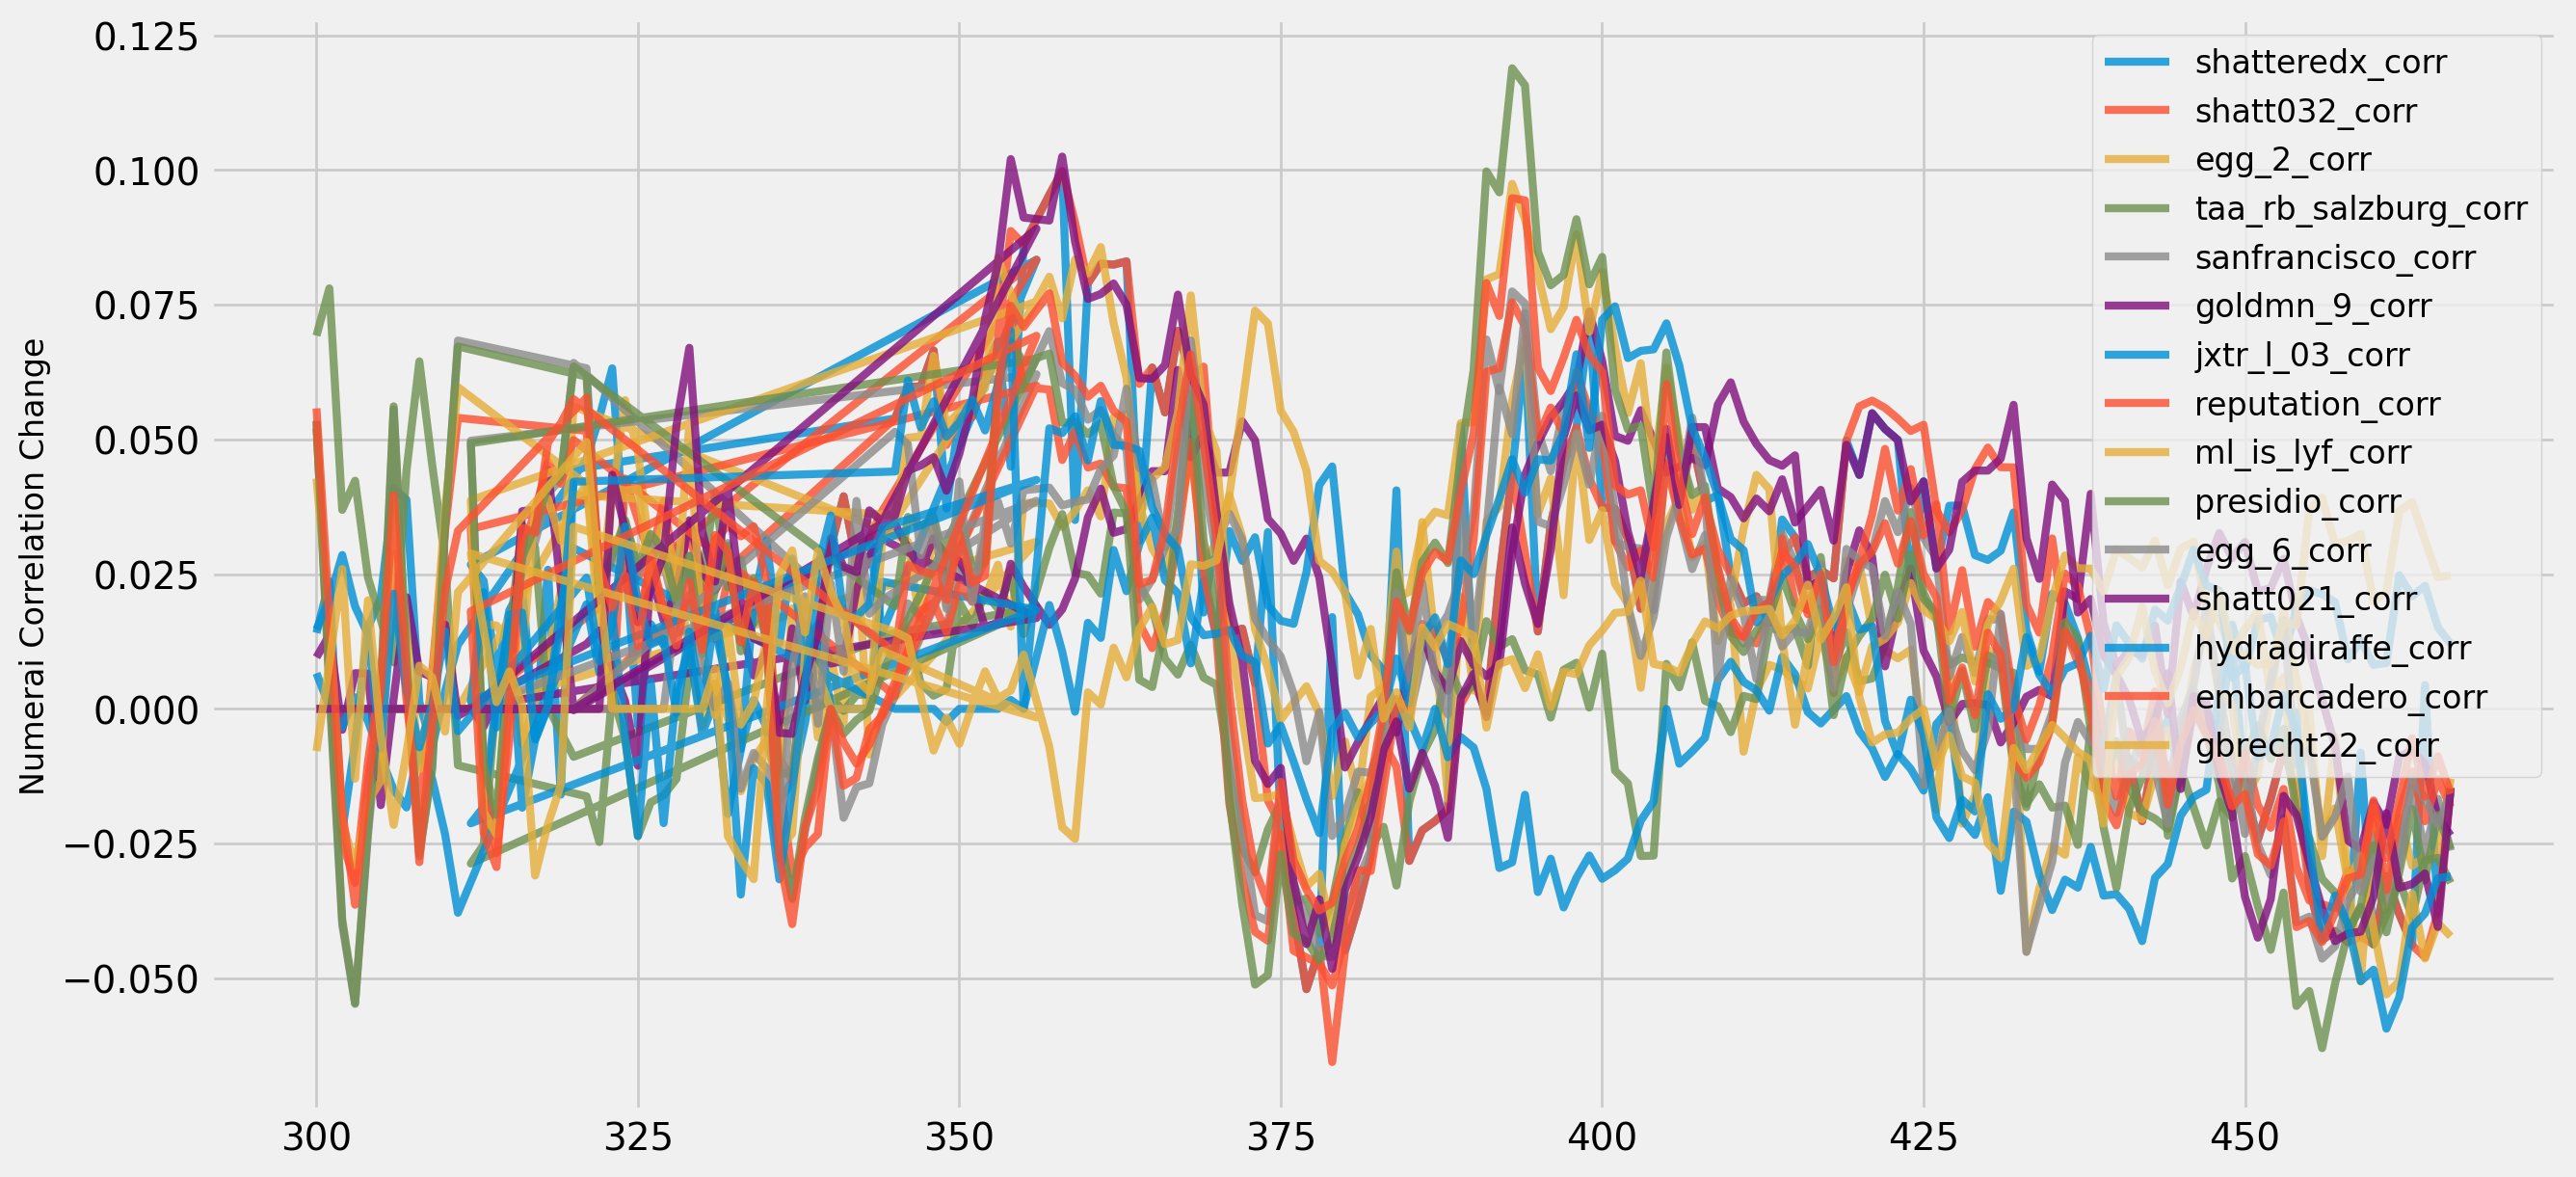

In [14]:
# Plot the corr change over time
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

corr_cols=[col for col in metrics_summary_new.columns if col.endswith('_corr')]
corr_returns = metrics_summary_new[corr_cols]
plt.figure(figsize=(14, 7))
for c in corr_returns.columns.values:
    plt.plot(corr_returns.index, corr_returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('Numerai Correlation Change', fontsize=12)

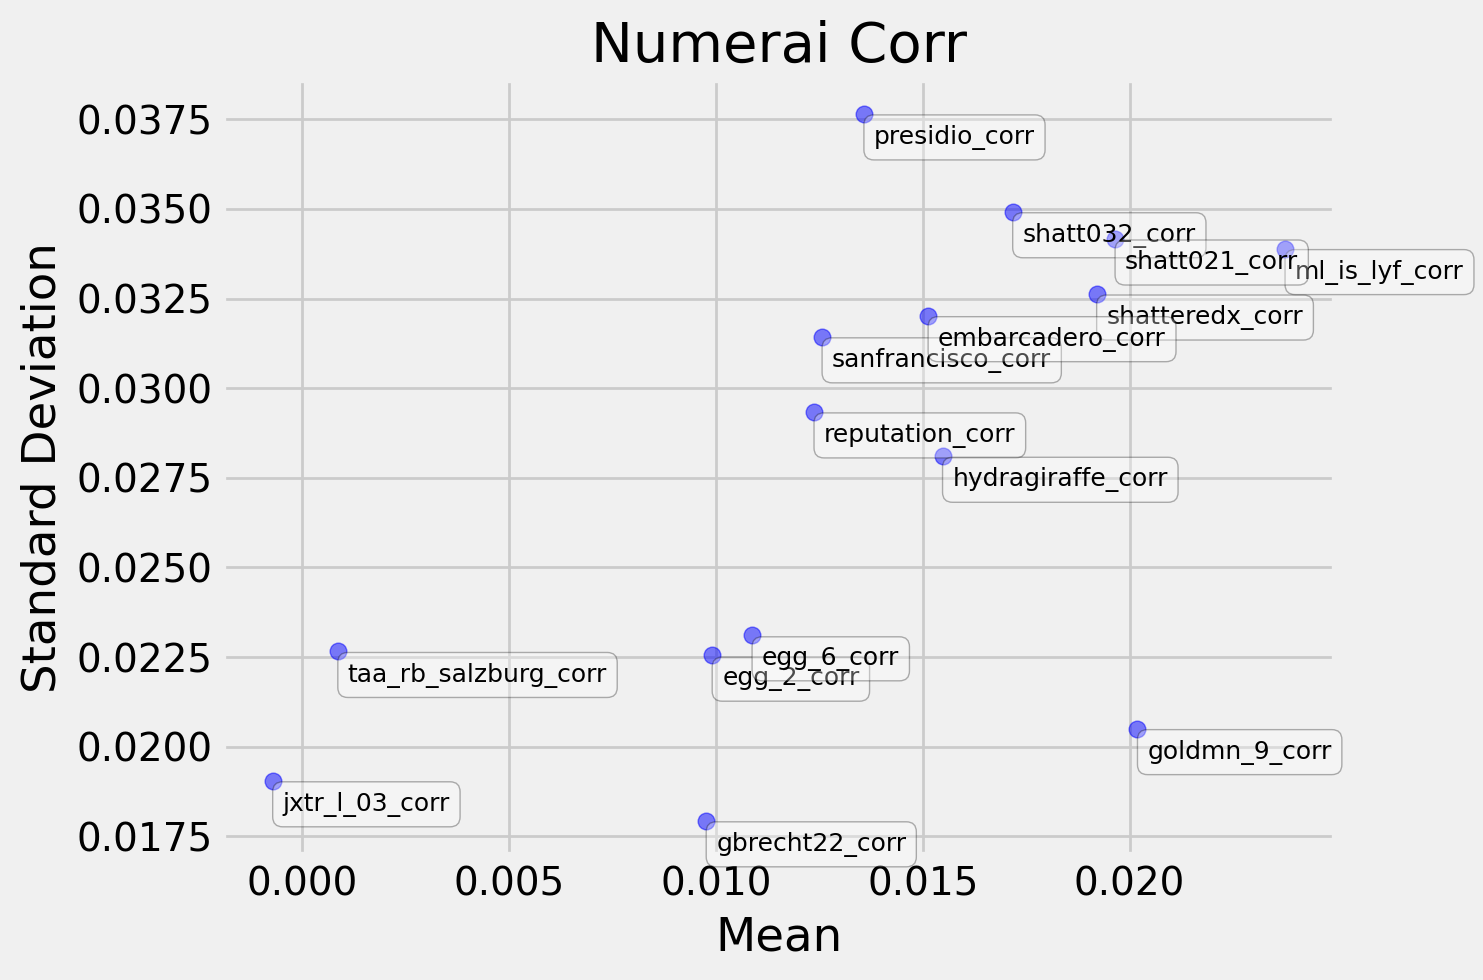

In [15]:
# Plot a scatterplot for all models' mean vs. standard deviation
metric_name='Numerai Corr'
all_mean=corr_returns.mean(axis=0)
all_std=corr_returns.std(axis=0)
temp_df=pd.concat([all_mean,all_std],axis=1).rename({0:'mean',1:'std'},axis=1)

import matplotlib.pyplot as plt
plt.scatter(all_mean, all_std,
            color='blue', alpha=0.5)

for i, model_name in enumerate(temp_df.index):
    plt.annotate(model_name, 
                (all_mean[i], all_std[i]),
                 xytext=(10,-30),textcoords='offset pixels',fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.4', fc='white', ec='black', alpha=0.3),
                )
    
# Add axis labels and title
plt.xlabel(f'Mean')
plt.ylabel('Standard Deviation')
plt.title(f'{metric_name}')

# Display the plot
plt.show()

- True Contribution

Text(0, 0.5, 'Numerai Correlation Change')

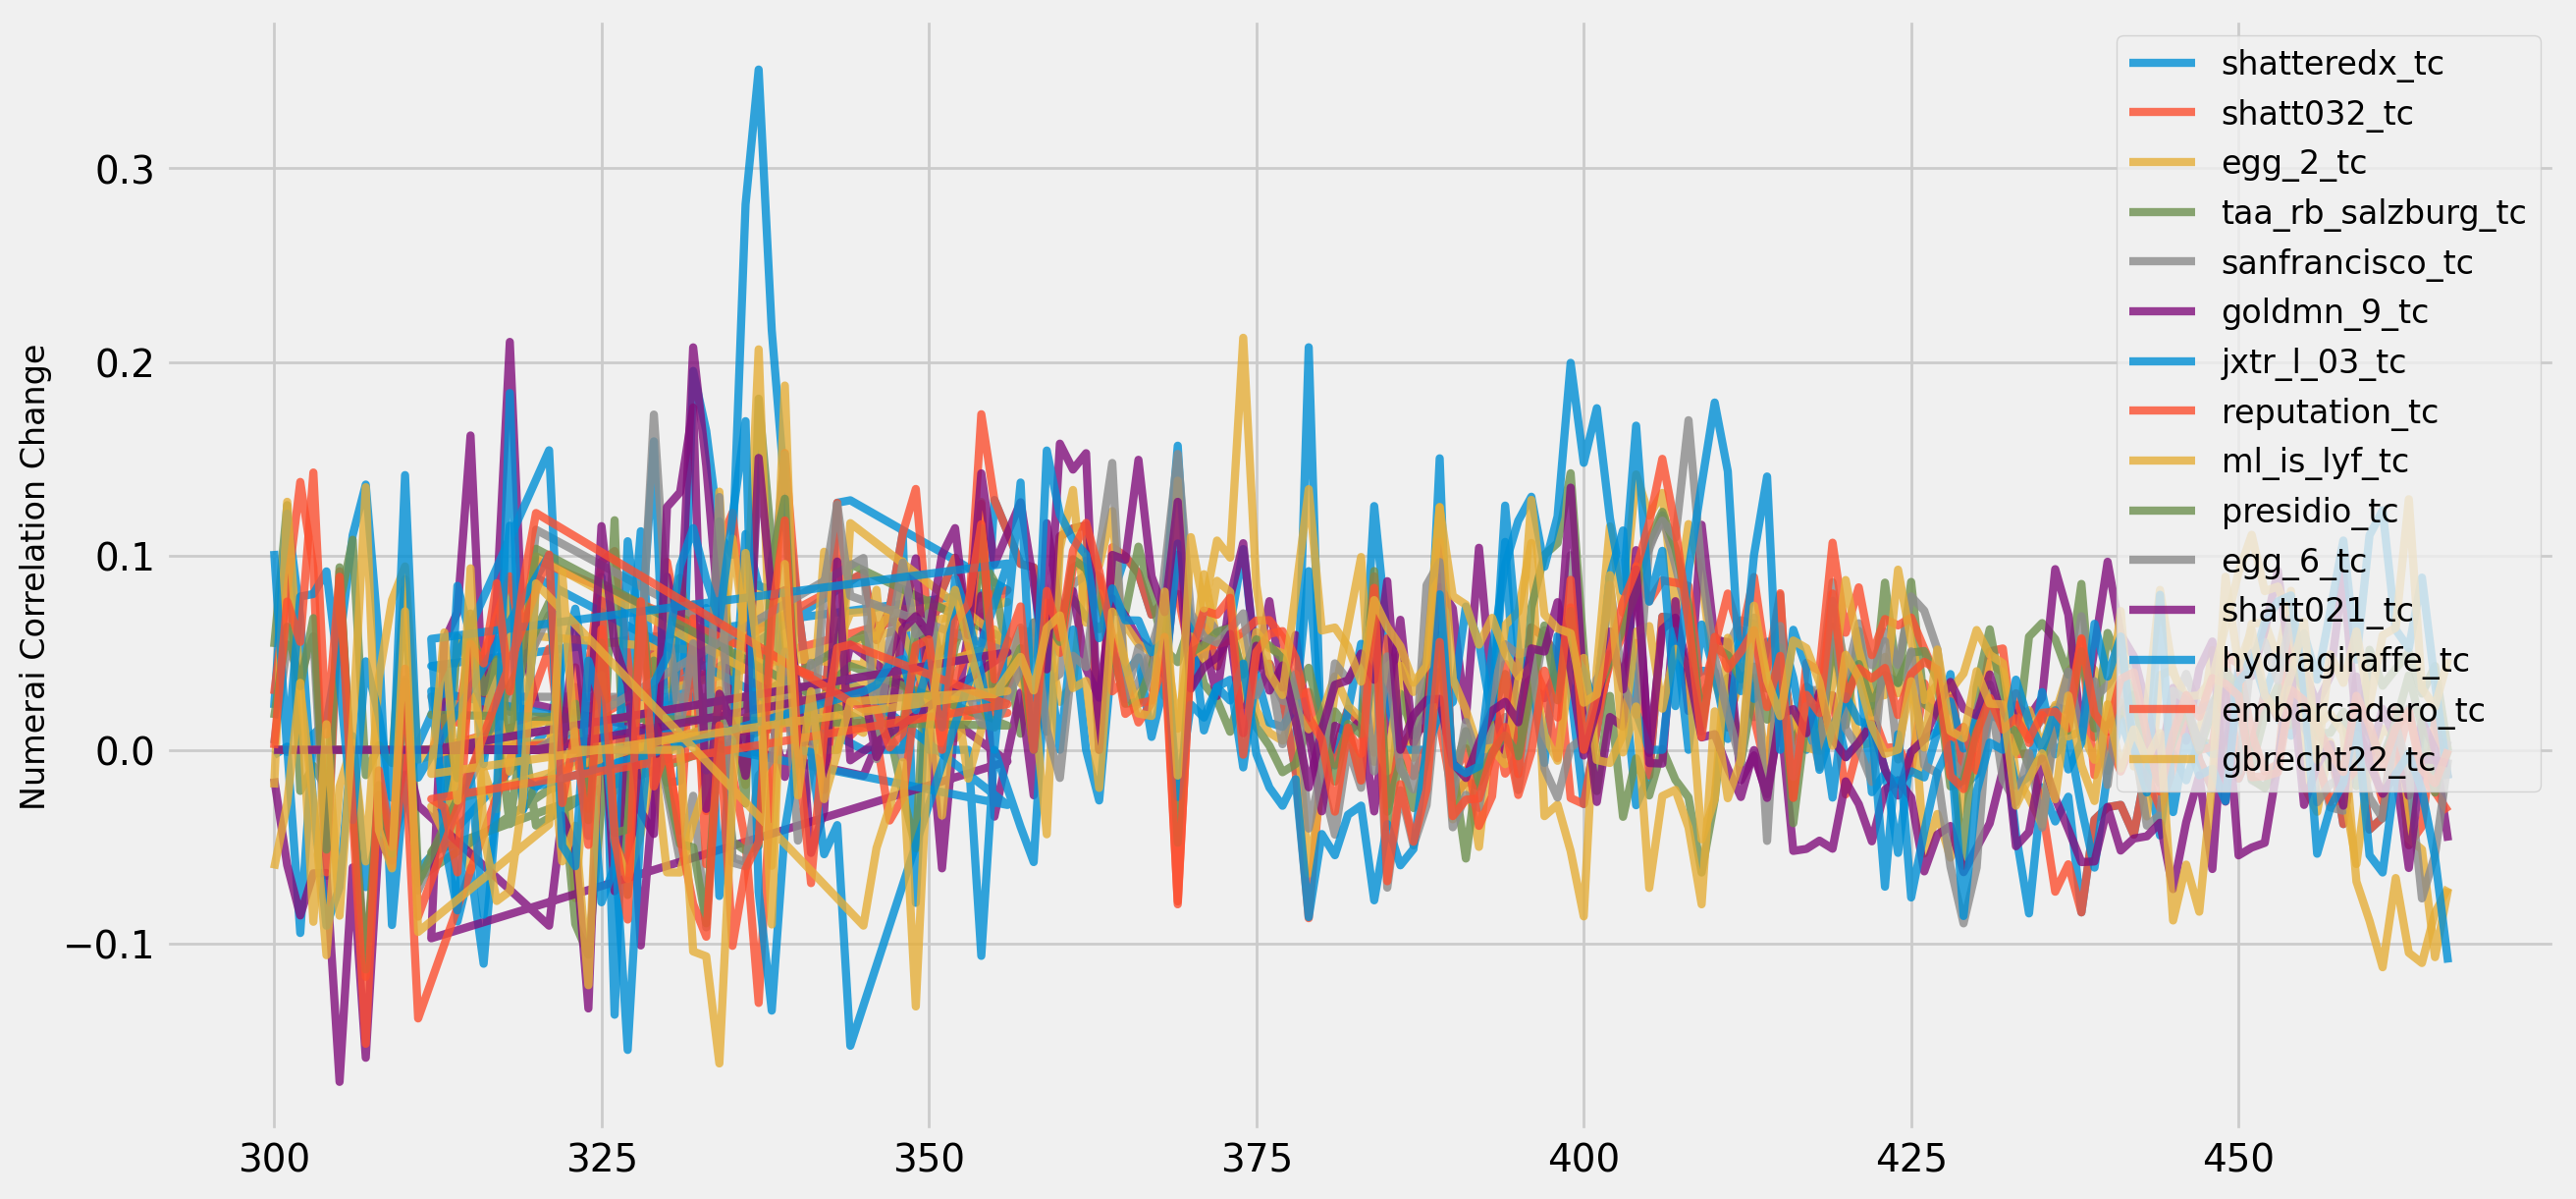

In [16]:
# Plot the corr change over time
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tc_cols=[col for col in metrics_summary_new.columns if col.endswith('_tc')]
tc_returns = metrics_summary_new[tc_cols]
plt.figure(figsize=(14, 7))
for c in tc_returns.columns.values:
    plt.plot(tc_returns.index, tc_returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('Numerai Correlation Change', fontsize=12)

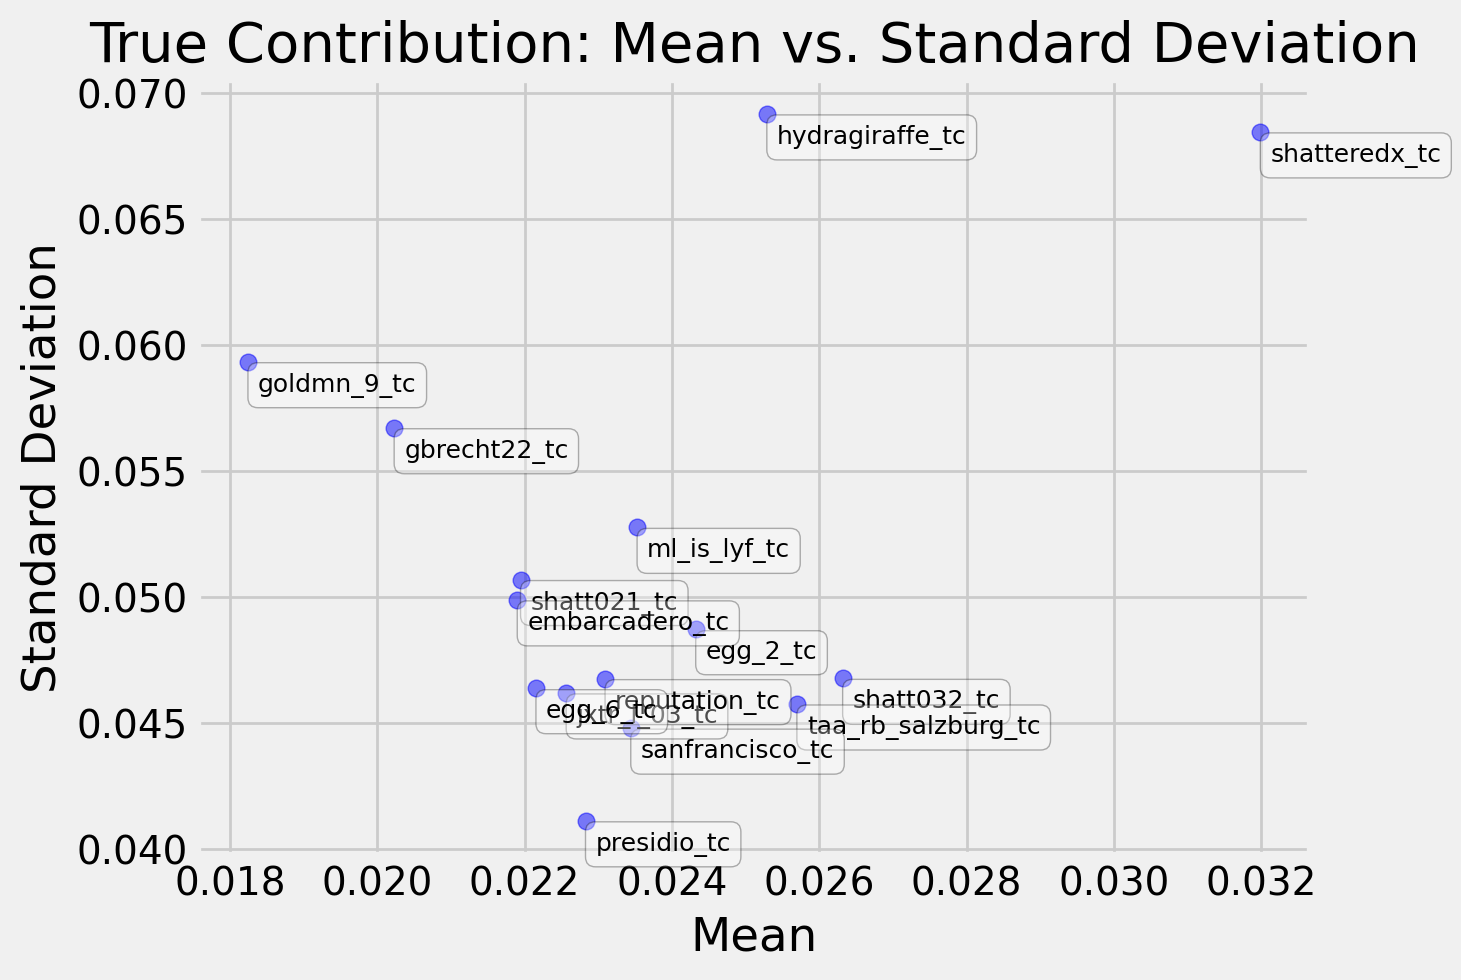

In [17]:
# Plot a scatterplot for all models' mean vs. standard deviation
metric_name='True Contribution'
all_mean=tc_returns.mean(axis=0)
all_std=tc_returns.std(axis=0)
temp_df=pd.concat([all_mean,all_std],axis=1).rename({0:'mean',1:'std'},axis=1)

import matplotlib.pyplot as plt
plt.scatter(all_mean, all_std,
            color='blue', alpha=0.5)

for i, model_name in enumerate(temp_df.index):
    plt.annotate(model_name, 
                (all_mean[i], all_std[i]),
                 xytext=(10,-30),textcoords='offset pixels',fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.4', fc='white', ec='black', alpha=0.3),
                )
    
# Add axis labels and title
plt.xlabel(f'Mean')
plt.ylabel('Standard Deviation')
plt.title(f'{metric_name}: Mean vs. Standard Deviation')

# Display the plot
plt.show()

In [18]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix, multiplier=1, payout_factor=0.1):
    # This function calculates the annualized returns and volatility of a portfolio
    # Assumes portfolio will compound over the year
    
    # TODO: implement random multipliers for corr and TC
    weights=weights*multiplier[0]*payout_factor
    returns = np.sum(mean_returns*weights) *52*5 #52 weeks per year, 5 rounds per week
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(52*5) #52 weeks per year, 5 rounds per week
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate, rand_multiplier=False):
    '''
    This function generates random portfolios with the following inputs:
    # num_portfolios: number of portfolios to be generated
    # mean_returns: expected returns for each stock
    # cov_matrix: covariance of returns for each stock
    # risk_free_rate: risk free rate
    '''
    results = np.zeros((3,num_portfolios))
    weights_record = []
    multiplier_record=[]
    corr_multipliers=[0,0.5,1]
    tc_multipliers=[0,0.5,1,2,3] # skip 1.5, 2.5 for now
    
    for i in range(num_portfolios):
        # Generate random weights by no. of models
        weights = np.random.random(len(mean_returns)) # generate random weights by no. of models
        weights /= np.sum(weights)
        weights_record.append(weights)
        
        # Calculate each portfolio's annualized return and volatility (standard dev.)
        # TODO: implement random multipliers for corr and TC
        if rand_multiplier:
            # Pick random multipliers for each of corr/TC
            multipliers=(np.random.choice(corr_multipliers,size=mean_returns.shape[0]),
                         np.random.choice(tc_multipliers,size=mean_returns.shape[0]))
            multiplier_record.append(multipliers)
            portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix, multipliers)
        else:
            # Default corr multiplier=1, TC multiplier=0
            multipliers=(np.ones(mean_returns.shape[0]),
                         np.zeros(mean_returns.shape[0]))
            multiplier_record.append(multipliers)
            portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix, multipliers)
        
        # Store the portfolio's standard dev
        results[0,i] = portfolio_std_dev
        # Store portfolio's return
        results[1,i] = portfolio_return
        # Store portfolio's Sharp ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record, multiplier_record

In [19]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights_record, multiplier_record = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    #TODO: implement random multipliers for corr and TC
    max_sharpe_allocation = pd.DataFrame(zip(weights_record[max_sharpe_idx],multiplier_record[max_sharpe_idx][0]),
                                         index=mean_returns.index, 
                                         columns=['allocation','multiplier'])    
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(zip(weights_record[min_vol_idx],multiplier_record[min_vol_idx][0]),
                                      index=mean_returns.index, 
                                      columns=['allocation','multiplier'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised volatility')
    plt.ylabel('Annualised returns')
    plt.legend(labelspacing=0.8)

In [20]:
# Currently only support _corr or _tc only
corr_cols = [col for col in metrics_summary_new.columns if col.endswith('_corr')]
tc_cols = [col for col in metrics_summary_new.columns if col.endswith('_tc')]
returns = metrics_summary_new[corr_cols] #tc_cols
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 100000 # Suggested to be number_of_models *50000
risk_free_rate = 0.01

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.33
Annualised Volatility: 0.02


            shatteredx_corr  shatt032_corr  egg_2_corr  taa_rb_salzburg_corr  sanfrancisco_corr  goldmn_9_corr  jxtr_l_03_corr  reputation_corr  ml_is_lyf_corr  presidio_corr  egg_6_corr  shatt021_corr  hydragiraffe_corr  embarcadero_corr  gbrecht22_corr
allocation             8.16           1.04       15.04                  3.12               0.07          14.95           15.79             1.06            9.82           1.06        1.73           5.73               2.39              2.49           17.53
multiplier             1.00           1.00        1.00                  1.00               1.00           1.00            1.00             1.00            1.00           1.00        1.00           1.00               1.00              1.00            1.00
---------------------------------------------------------

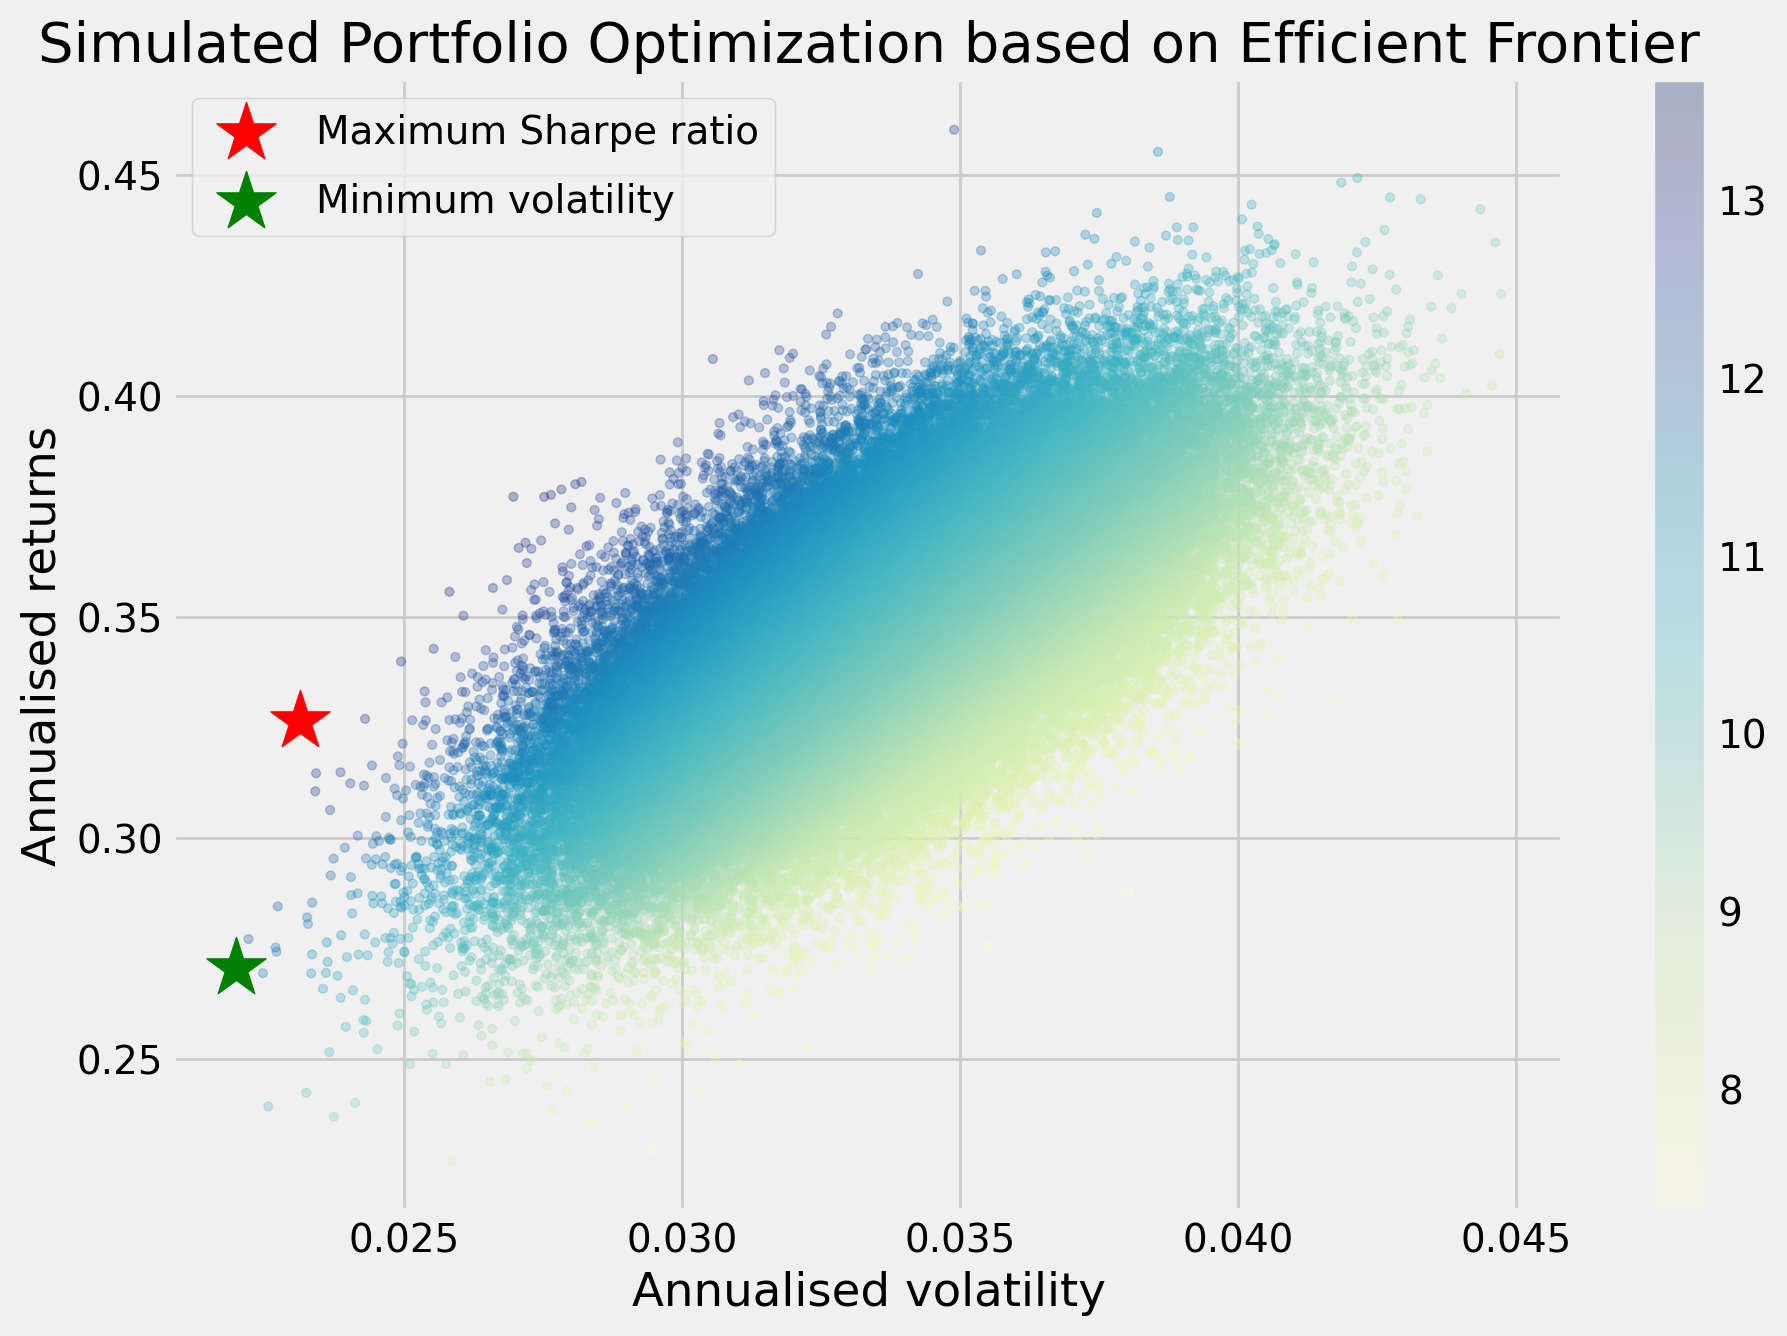

In [21]:
# Plot the efficient frontier for the simulated portfolios
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# Work-in-progress: Alternative method using pypfopt

In [ ]:
# Max drawdown calculation
rolling_max = (
            (returns + 1)
            .cumprod()
            .rolling(window=9000, min_periods=1)  # arbitrarily large
            .max()
        )
daily_value = (returns + 1).cumprod()
max_drawdown = -((rolling_max - daily_value) / rolling_max).max()

In [266]:
#corr_summary=corr_summary[['eses_waiga','eses_1','eses_3','eses_c','eses_6']]

In [ ]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns, EfficientSemivariance

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(corr_summary)
S = risk_models.sample_cov(corr_summary)
mu

In [ ]:
# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

In [ ]:
mu = expected_returns.mean_historical_return(corr_summary)
historical_returns = expected_returns.returns_from_prices(corr_summary)
es = EfficientSemivariance(mu, historical_returns)
es.efficient_return(0.20)

In [ ]:
from pypfopt import plotting

ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
#ef.add_constraint(lambda w: w[2] == 0.15)
#ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

In [ ]:
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

In [ ]:
"""
round_result_df[['corr','corrPercentile',
                 'fncV3','fncV3Percentile',
                 'tc','tcPercentile']]
"""
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

In [ ]:
round_result_df.columns

In [ ]:
risk_models.risk_matrix(round_result_df['corr'])

In [ ]:
round_result_df['corr'].cov(round_result_df['corr'])

In [ ]:
risk_models.CovarianceShrinkage(round_result_df[['corr']])

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage

mu = returns.mean()
S = returns.cov()
#S = CovarianceShrinkage(returns).ledoit_wolf()

In [ ]:
mu

shatteredx      0.019202
sanfrancisco    0.012564
reputation      0.012369
ml_is_lyf       0.023757
hydragiraffe    0.015476
dtype: float64

In [ ]:
S

shatteredx  sanfrancisco  reputation  ml_is_lyf  hydragiraffe
shatteredx      0.001064      0.000728    0.000648   0.000752      0.000606
sanfrancisco    0.000728      0.000988    0.000893   0.000907      0.000543
reputation      0.000648      0.000893    0.000861   0.000816      0.000475
ml_is_lyf       0.000752      0.000907    0.000816   0.001149      0.000747
hydragiraffe    0.000606      0.000543    0.000475   0.000747      0.000790

In [ ]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
weights

OrderedDict([('shatteredx', 0.0),
             ('sanfrancisco', 0.0),
             ('reputation', 0.0),
             ('ml_is_lyf', 1.0),
             ('hydragiraffe', 0.0)])

In [ ]:
cleaned_weights = ef.clean_weights()
ef.portfolio_performance(verbose=True)


Expected annual return: 2.4%
Annual volatility: 3.4%
Sharpe Ratio: 0.11


(0.023757345453363082, 0.03389160140692485, 0.11086361509596204)

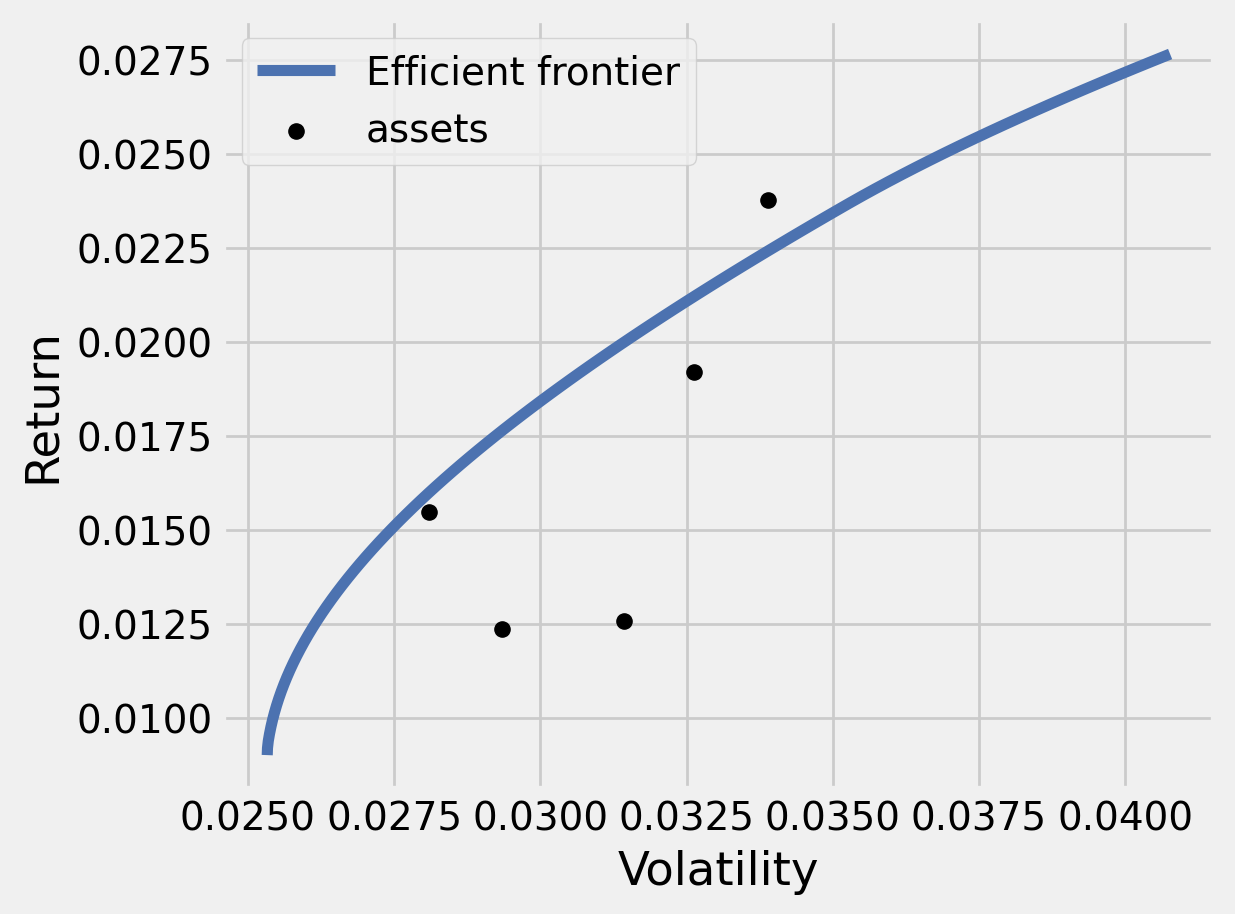

In [ ]:
from pypfopt import plotting

ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()